In [ ]:
# default_exp models.predict

# Predict

> Prediction and export outputs.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.dataloaders import *
from steel_segmentation.models.metrics import *
from steel_segmentation.models.model import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import cv2
import pathlib
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

pred_path = path.parent / "predictions"
pred_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

In this notebook the *functions* provided can be used to make inference with the models trained and saved in `models_dir`.

The first section is related to the fast.ai API while the second is for a general Pytorch approach.

In [ ]:
# missing
print_competition_data(models_dir)

../models/ResNet18-Unet-kaggle.pth
../models/.ipynb_checkpoints
../models/ResNet18-Classifier-kaggle.pth
../models/ResNet34-Unet-256-stage5.pth
../models/ResNet34-Unet-256-stage3.pth
../models/ResNet34-Unet-128-stage2.5.pth


## Fast.ai prediction

First, we need to load a `segmentation_learner` with the right `parameters`.

In [ ]:
arch = resnet34
bs = 4 
dls = get_segmentation_dls_from_df(train_df=train_multi, bs=bs, size=(256, 1600))
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

In [ ]:
# missing
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage5")

In [ ]:
# export
class Predict:
    pred_mask_path = pred_path / "prediction_masks"
    pred_mask_path.mkdir(parents=True, exist_ok=True)
    
    def __init__(self, 
                 source, 
                 learner,
                 source_path:pathlib.Path=None):
        self.source = source 
        self.learner = learner
        self.source_path = source_path if source_path else train_path
        
        self.single_prediction = False
        
        if isinstance(self.source, pathlib.Path):
            self.img_paths = self.get_path_source_list()
        elif isinstance(self.source, pd.DataFrame):
            self.img_paths = self.get_df_source_list()
        elif isinstance(self.source, list):
            self.img_paths = self.source
        elif isinstance(self.source, str):
            self.single_prediction = True
            self.img_paths = L(self.source_path / self.source)

        self.elems = len(self.img_paths)
    
    def get_df_source_list(self):
        """Load `source` if it's a DataFrame instance."""
        tfm = ColReader("ImageId", pref=self.source_path)
        return L([tfm(o) for o in self.source.itertuples()])
        
    def get_path_source_list(self):
        """Load `source` if it's a pathlib.Path instance."""
        return get_image_files(self.source)
    
    def predict(self, selected_imgs):
        """Get the predictions on the `selected_imgs`."""
        if self.single_prediction:
            pred_full_dec, pred_dec, out = self.learner.predict(selected_imgs[0])
            return out.unsqueeze(dim=0)
            
        test_dl = self.learner.dls.test_dl(test_items=selected_imgs)
        pred_probs,_,_ = self.learner.get_preds(dl=test_dl, with_decoded=True)
        
        return pred_probs
    
    def post_process(self, probability):
        """
        Post processing of each predicted mask, components with lesser number of pixels
        than `min_size` are ignored.
        """
        mask = cv2.threshold(probability, self.threshold, 1, cv2.THRESH_BINARY)[1]
        num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
        predictions = np.zeros((256, 1600), np.float32)
        num = 0
        for c in range(1, num_component):
            p = (component == c)
            if p.sum() > self.min_size:
                predictions[p] = 1
                num += 1
        return predictions, num
    
    def get_RLEs(self, img_names, pred_probs):
        """For each image in the batch to predict, 
        returns a list of tuples with `(img_id, rle)`."""
        predictions = []
        
        for num_pred, t_pred in enumerate(pred_probs): # img in bs
            np_pred = t_pred.numpy()

            # iterate through class_id without class_id 0
            for class_id, prob in enumerate(np_pred[1:]): 
                pred, num = self.post_process(prob)
                rle = mask2rle(pred)
                name = img_names[num_pred] + f"_{class_id+1}"
                predictions.append([name, rle])
        
        return pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
    
    def save_df(self, df, file_name):
        """Save the final DataFrame into the `pred_path` folder."""
        df.to_csv(pred_path/file_name, index=False)
    
    def get_predictions(self):
        """Iterate through `Predict.folds`, predict the mask and
        get the RLEs in a DataFrame."""
        df_preds = []
        
        for fold in range(self.folds):
            start, end = fold*self.size_fold, (fold+1)*self.size_fold
            print(f"From {start} to {end} of {self.elems}")
            
            selected_imgs = self.img_paths[start:end]
            
            img_names = selected_imgs.map(Path).map(lambda x: x.name)
            pred_probs = self.predict(selected_imgs)            
            
            tmp_df = self.get_RLEs(img_names, pred_probs)
            df_preds.append(tmp_df)

            torch.cuda.empty_cache()
        
        if len(df_preds) == 1:
            return df_preds[0]
        
        df = pd.concat(df_preds, axis=0, ignore_index=True)
        return df.fillna("", inplace=True)
    
    def save_masks(self, df_export_name=None, json=False):
        """Iterate through the RLEs in `Predict.df` and save the masks.
        Returns the `Predict.df_masks` DataFrame (if not `json`) with
        `columns=['ImageId', 'ClassId', 'Mask_path']`.
        If `df_export_name`, it saves the DataFrame and the JSON in `pred_path`.
        If `json`, it returns the JSON file instead the DataFrame.
        """
        rows = []
        for row in self.df.itertuples():
            if row.EncodedPixels != '':
                img_id, class_id = row.ImageId_ClassId.split("_")
                img_id = img_id.split(".")[0]
                img_label = img_id + "_pred.png"
                img_path = self.pred_mask_path / img_label

                mask = rle_to_mask(row.EncodedPixels, class_id, 256, 1600)
                im = Image.fromarray(mask)
                im.save(img_path)

                rows.append((img_id + ".jpg", class_id, img_label))
        
        self.df_masks = pd.DataFrame(rows, columns=['ImageId', 'ClassId', 'Mask_path'])
        
        if df_export_name:
            csv_name = pred_path/(df_export_name + ".csv")
            json_name = pred_path/(df_export_name + ".json")
            self.df_masks.to_csv(csv_name, index=False)
            self.df_masks.to_json(json_name, orient="table", indent=4)

        if json:
            return self.df_masks.to_json(orient="table")
        
        return self.df_masks
    
    def __call__(self, size_fold:int, threshold:float, min_size:int):
        """Call the object with prediction attributes, 
        it calls `Predict.get_predictions`
        and returns the `Predict.df` DataFrame with RLEs."""
        self.size_fold = min([self.elems, size_fold])
        self.threshold = threshold
        self.min_size = min_size
        self.folds = self.elems // self.size_fold
        if (self.elems % self.size_fold) != 0:
            self.folds += 1
            
        self.df = self.get_predictions()
        return self.df
    
    def plot(self, n:int=5, rand=True):
        if (self.df_masks is None)|(self.df is None):
            return "Nothing to plot, first call the class to get the predictions"
        
        if rand:
            path_list = get_perm_imgs_path(self.img_paths.map(Path), self.df_masks)
        else:
            path_list = self.img_paths.map(Path)
            
        df = self.df.copy()
        splitted_cols = df["ImageId_ClassId"].str.split("_", expand=True)
        df["ImageId"], df["ClassId"] = splitted_cols[0], splitted_cols[1].astype("int64")
        
        for p in path_list[:n]:
            plot_defected_image(p, df)

In [ ]:
show_doc(Predict.predict)

<h4 id="Predict.predict" class="doc_header"><code>Predict.predict</code><a href="__main__.py#L37" class="source_link" style="float:right">[source]</a></h4>

> <code>Predict.predict</code>(**`selected_imgs`**)

Get the predictions on the `selected_imgs`.

The `Predict` class needs a `source`, as a list of images to infer, and a fast.ai `Learner`. The inference can be done on a single image or a bunch of images.

The `source` get a prediction with `Predict.predict` to get the masks. 
Every mask is processed by `Predict.post_process` to ignore small areas that can lead to false positives.

In [ ]:
show_doc(Predict.post_process)

<h4 id="Predict.post_process" class="doc_header"><code>Predict.post_process</code><a href="__main__.py#L48" class="source_link" style="float:right">[source]</a></h4>

> <code>Predict.post_process</code>(**`probability`**)

Post processing of each predicted mask, components with lesser number of pixels
than `min_size` are ignored.

The source can be a `DataFrame` as `df_tmp`: 

In [ ]:
df_tmp = train.iloc[0].to_frame().T
df_tmp.head()

,ImageId,ClassId,EncodedPixels,ImageId_ClassId
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...,0002cc93b.jpg_1


In [ ]:
show_doc(Predict.get_predictions)

<h4 id="Predict.get_predictions" class="doc_header"><code>Predict.get_predictions</code><a href="__main__.py#L85" class="source_link" style="float:right">[source]</a></h4>

> <code>Predict.get_predictions</code>()

Iterate through [`Predict.folds`](/steel_segmentation/model.predict.html#Predict.folds), predict the mask and
get the RLEs in a DataFrame.

In [ ]:
# test arguments
size_fold = 100
threshold = 0.5
min_size = 3000

pred = Predict(df_tmp, segmentation_learner)

In [ ]:
show_doc(Predict.__call__)

<h4 id="Predict.__call__" class="doc_header"><code>Predict.__call__</code><a href="__main__.py#L144" class="source_link" style="float:right">[source]</a></h4>

> <code>Predict.__call__</code>(**`size_fold`**:`int`, **`threshold`**:`float`, **`min_size`**:`int`)

Call the object with prediction attributes, 
it calls [`Predict.get_predictions`](/steel_segmentation/model.predict.html#Predict.get_predictions)
and returns the [`Predict.df`](/steel_segmentation/model.predict.html#Predict.df) DataFrame with RLEs.

In [ ]:
df_pred = pred(size_fold, threshold, min_size)
df_pred

From 0 to 1 of 1


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,77411 11 77665 17 77918 20 78172 24 78427 26 78681 31 78937 30 79194 32 79229 1 79231 7 79239 1 79241 1 79271 1 79273 1 79275 1 79277 1 79279 1 79281 1 79283 1 79449 33 79485 1 79487 1 79489 9 79499 1 79519 1 79521 1 79523 1 79525 1 79527 1 79529 13 79543 1 79705 53 79759 1 79771 1 79773 31 79962 31 79996 1 79999 14 80015 1 80019 1 80021 1 80023 1 80025 35 80218 31 80255 3 80259 11 80271 48 80474 31 80513 13 80527 1 80529 1 80531 1 80533 43 80730 32 80767 67 80987 30 81024 1 81027 2 81030 3 81034 1 81036 1 81040 1 81043 46 81243 30 81279 15 81295 2 81299 47 81499 29 81538 1 81540 1 81542 1...
1,0002cc93b.jpg_2,
2,0002cc93b.jpg_3,
3,0002cc93b.jpg_4,


And can predict a single image mask:

In [ ]:
source = "f383950e8.jpg"
pred = Predict(source, segmentation_learner)
df_pred = pred(size_fold, threshold, min_size)
df_pred

From 0 to 1 of 1


,ImageId_ClassId,EncodedPixels
0,f383950e8.jpg_1,
1,f383950e8.jpg_2,
2,f383950e8.jpg_3,
3,f383950e8.jpg_4,314087 26 314342 27 314590 35 314846 35 315088 1 315090 47 315344 49 315586 63 315841 64 316088 73 316345 72 316599 74 316855 74 317110 75 317365 76 317615 82 317870 83 318119 90 318374 91 318624 97 318878 1 318880 97 319118 1 319120 113 319374 115 319622 123 319877 124 320129 128 320385 128 320637 132 320893 132 321146 135 321400 137 321652 141 321908 141 322159 146 322415 146 322666 151 322922 151 323171 158 323426 159 323678 163 323932 165 324183 170 324438 171 324691 174 324947 174 325199 178 325454 179 325707 182 325962 183 326215 186 326470 187 326722 191 326974 1 326976 193 327222 1...


Another example with more elements in the DataFrame:

In [ ]:
# with 5 elements
df_tmp = segmentation_learner.dls.valid.items.iloc[:5]
df_tmp.shape

(5, 2)

In [ ]:
pred = Predict(df_tmp, segmentation_learner)
df_pred = pred(size_fold, threshold, min_size)
print(df_pred.shape)
df_pred.head()

From 0 to 5 of 5


(20, 2)


,ImageId_ClassId,EncodedPixels
0,b5352d213.jpg_1,
1,b5352d213.jpg_2,
2,b5352d213.jpg_3,219065 4 219317 11 219572 13 219828 13 220083 14 220338 17 220594 17 220849 18 221104 20 221360 20 221616 21 221871 22 222126 23 222382 24 222638 24 222893 25 223149 25 223405 26 223661 26 223916 27 224172 27 224427 28 224683 28 224938 29 225194 29 225450 29 225706 29 225961 30 226217 30 226473 30 226729 30 226985 29 227240 30 227496 30 227752 30 228007 31 228263 31 228519 30 228774 31 229030 31 229286 31 229542 30 229798 30 230054 30 230310 29 230566 29 230821 30 231077 29 231333 29 231589 28 231845 28 232101 28 232357 28 232613 27 232870 26 233126 25 233382 25 233638 25 233894 25 234149 ...
3,b5352d213.jpg_4,
4,ecb50399d.jpg_1,


In [ ]:
show_doc(Predict.save_masks)

<h4 id="Predict.save_masks" class="doc_header"><code>Predict.save_masks</code><a href="__main__.py#L110" class="source_link" style="float:right">[source]</a></h4>

> <code>Predict.save_masks</code>(**`df_export_name`**=*`None`*, **`json`**=*`False`*)

Iterate through the RLEs in [`Predict.df`](/steel_segmentation/model.predict.html#Predict.df) and save the masks.
Returns the [`Predict.df_masks`](/steel_segmentation/model.predict.html#Predict.df_masks) DataFrame (if not `json`) with
`columns=['ImageId', 'ClassId', 'Mask_path']`.
If `df_export_name`, it saves the DataFrame and the JSON in [`pred_path`](/steel_segmentation/model.predict.html#pred_path).
If `json`, it returns the JSON file instead the DataFrame.

In [ ]:
df_masks = pred.save_masks(df_export_name="test_export", json=True)
df_masks

'{"schema":{"fields":[{"name":"index","type":"integer"},{"name":"ImageId","type":"string"},{"name":"ClassId","type":"string"},{"name":"Mask_path","type":"string"}],"primaryKey":["index"],"pandas_version":"0.20.0"},"data":[{"index":0,"ImageId":"b5352d213.jpg","ClassId":"3","Mask_path":"b5352d213_pred.png"},{"index":1,"ImageId":"ecb50399d.jpg","ClassId":"4","Mask_path":"ecb50399d_pred.png"},{"index":2,"ImageId":"39e365d3b.jpg","ClassId":"3","Mask_path":"39e365d3b_pred.png"},{"index":3,"ImageId":"06e6582af.jpg","ClassId":"3","Mask_path":"06e6582af_pred.png"}]}'

In [ ]:
df_masks = pred.save_masks()
df_masks

,ImageId,ClassId,Mask_path
0,b5352d213.jpg,3,b5352d213_pred.png
1,ecb50399d.jpg,4,ecb50399d_pred.png
2,39e365d3b.jpg,3,39e365d3b_pred.png
3,06e6582af.jpg,3,06e6582af_pred.png


In [ ]:
pred_path.ls()

(#3) [Path('../predictions/test_export.csv'),Path('../predictions/test_export.json'),Path('../predictions/prediction_masks')]

Visualize defects:

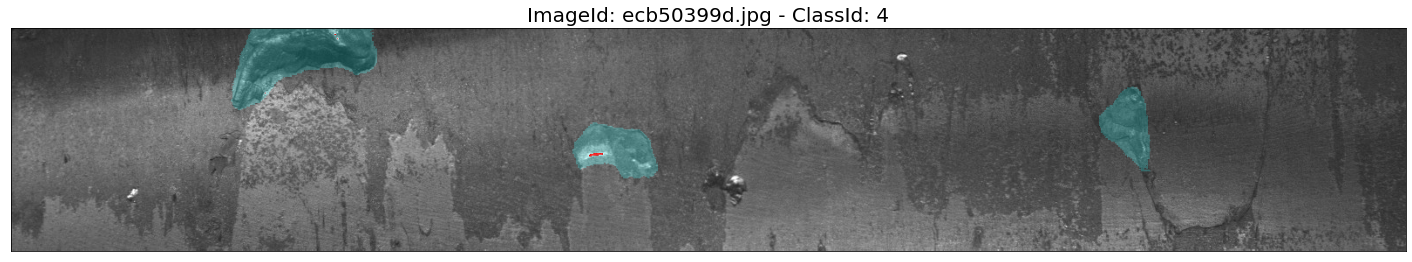

In [ ]:
pred.plot(n=1, rand=True)

## Pytorch prediction

In [ ]:
pass

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()

Converted 01_core.ipynb.
Converted 02_data.ipynb.
Converted 03_dataloaders.ipynb.
Converted 04_model.metrics.ipynb.
Converted 05_models.unet.ipynb.
Converted 06_models.model.ipynb.
Converted 07_model.predict.ipynb.
Converted index.ipynb.
